<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

import numpy as np

from scipy.interpolate import griddata

import matplotlib.pyplot as plt


# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA')
else:
    device = torch.device('cpu')
    print('CPU')

CUDA


In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [3]:
class NN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        # initialize weight and Biases
        nn.init.xavier_uniform_(self.l1.weight)
        self.l1.bias.data.fill_(0.0)

        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l2.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l2.weight)

        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l3.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l3.weight)

        self.l4 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_uniform_(self.l4.weight)
        self.l4.bias.data.fill_(0.0)

    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        return out

In [4]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, bcs_sampler, res_sampler, k, l, kernel_size):

        # Normalization
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # weights
        self.lam_u_val = torch.tensor(1.0).float().to(device)
        self.lam_r_val = torch.tensor(1.0).float().to(device)

        # Constant
        self.k = torch.tensor(k).float().to(device)
        self.l = torch.tensor(l).float().to(device)

        self.kernel_size = kernel_size # Size of the NTK matrix

        self.D1 = self.kernel_size    # boundary
        self.D2 = self.kernel_size    # ut
        self.D3 = self.kernel_size    # residual  D1 = D3 = 3D2

        # Neural Network
        self.nn = NN(layers[0], layers[1], layers[-1]).to(device)

        self.optimizer_Adam = torch.optim.Adam(params=self.nn.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.optimizer_Adam, gamma=0.9)

        # Logger
        self.loss_bcs_log = []
        self.loss_res_log = []

        # NTK logger
        self.K_u_log = []
        self.K_r_log = []

        # weights logger
        self.lam_u_log = []
        self.lam_r_log = []

    #    self.u_pred_log = []

    # Forward pass for u
    def net_u(self, t, x):

        if x.dim()==0:
            x = x.reshape(1)
            t = t.reshape(1)
            u = self.nn(torch.cat([t, x], dim=0))
        else:
            u = self.nn(torch.cat([t, x], dim=1))
        return u

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x, self.k, self.l)
        return residual

    # Gradient operation
    def gradient(self, y, x, grad_outputs=None):
        if grad_outputs is None:
            grad_outputs = torch.ones_like(y)
        grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True, allow_unused=True)[0]
        return grad

    # Compute Jacobian for each weights and biases in each layer and return a list
    def compute_jacobian(self, output, params):
        output = output.reshape(-1)
        J_dum = []
        J_List = []

        for i in range(len(params)):
            grad, = torch.autograd.grad(output, params[i], (torch.eye(output.shape[0]).to(device),),retain_graph=True, allow_unused=True, is_grads_batched=True)
            if grad == None:
                pass
            else:
                J_dum.append(grad)

                if np.mod(i,2)==1:
                    if grad == None:
                        pass
                    J_List.append(torch.cat((J_dum[i-1].flatten().reshape(len(output),-1),grad.flatten().reshape(len(output),-1)), 1))
        return J_List

    # Compute Neural Tangent Kernel's Trace Values
    def compute_ntk(self, J1, d1, J2, d2):

        Ker = torch.zeros((d1,d2)).float().to(device)

        for i in range(len(J1)):
            K = torch.matmul(J1[i], J2[i].t())
            Ker = Ker + K
        return Ker


    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):

        # NTK
        self.nn.train()

        saved_predictions = []

        for it in range(nIter):
            # Fetch boundary mini-batches
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 4)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 4)
            X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size // 4)
            X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size // 4)

            # Tensor

            X_bc1_batch_tens = torch.tensor(X_bc1_batch, requires_grad=True).float().to(device)
            u_bc1_batch_tens = torch.tensor(u_bc1_batch, requires_grad=True).float().to(device)

            X_bc2_batch_tens = torch.tensor(X_bc2_batch, requires_grad=True).float().to(device)
            u_bc2_batch_tens = torch.tensor(u_bc2_batch, requires_grad=True).float().to(device)

            X_bc3_batch_tens = torch.tensor(X_bc3_batch, requires_grad=True).float().to(device)
            u_bc3_batch_tens = torch.tensor(u_bc3_batch, requires_grad=True).float().to(device)

            X_bc4_batch_tens = torch.tensor(X_bc4_batch, requires_grad=True).float().to(device)
            u_bc4_batch_tens = torch.tensor(u_bc4_batch, requires_grad=True).float().to(device)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)
            X_res_batch_tens = torch.tensor(X_res_batch, requires_grad=True).float().to(device)

            u_pred_bc1 = self.net_u(X_bc1_batch_tens[:, 0:1], X_bc1_batch_tens[:, 1:2])
            u_pred_bc2 = self.net_u(X_bc2_batch_tens[:, 0:1], X_bc2_batch_tens[:, 1:2])
            u_pred_bc3 = self.net_u(X_bc3_batch_tens[:, 0:1], X_bc3_batch_tens[:, 1:2])
            u_pred_bc4 = self.net_u(X_bc4_batch_tens[:, 0:1], X_bc4_batch_tens[:, 1:2])

            r_pred = self.net_r(X_res_batch_tens[:, 0:1], X_res_batch_tens[:, 1:2])

            loss_bcs = torch.mean((u_pred_bc1-u_bc1_batch_tens) ** 2)+torch.mean((u_pred_bc2-u_bc2_batch_tens) ** 2)+torch.mean((u_pred_bc3-u_bc3_batch_tens) ** 2)+torch.mean((u_pred_bc4-u_bc4_batch_tens) ** 2)
            loss_res = torch.mean(r_pred ** 2)

            loss = self.lam_r_val * loss_res + self.lam_u_val * loss_bcs

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            if it % 1000 == 0:
                self.my_lr_scheduler.step()

            # Print
            if it % 100 == 0:

                # Store losses
                self.loss_bcs_log.append(loss_bcs.detach().cpu().numpy())
                self.loss_res_log.append(loss_res.detach().cpu().numpy())

                print('It: %d, Loss: %.3e, Loss_res: %.3e,  Loss_bcs: %.3e' %
                      (it, loss.item(), loss_res, loss_bcs))

                print(f'lambda_u: {self.lam_u_val:3e}')
                print(f'lambda_r: {self.lam_r_val:3e}')



            if log_NTK:

                if it % 100 == 0:
                    print("Compute NTK...")
                    X_bc_batch = np.vstack([X_bc1_batch, X_bc2_batch, X_bc3_batch, X_bc4_batch])

                    # Convert to the tensor
                    X_bc_batch_tens = torch.tensor(X_bc_batch, requires_grad=True).float().to(device)

                    # Get the parameters of NN
                    params = list(self.nn.parameters())

                    # Store the trace
                    K_u_value = 0
                    K_r_value = 0

                    u_ntk_pred = self.net_u(X_bc_batch_tens[:,0:1], X_bc_batch_tens[:,1:2])
                    r_ntk_pred = self.net_r(X_res_batch_tens[:,0:1], X_res_batch_tens[:,1:2])

                    # Jacobian of the neural networks
                    J_u = self.compute_jacobian(u_ntk_pred, params)
                    J_r = self.compute_jacobian(r_ntk_pred, params)

                    # Neural tangent kernels of the neural networks / Trace values
                    K_u_value = self.compute_ntk(J_u, self.D1, J_u, self.D1)
                    K_r_value = self.compute_ntk(J_r, self.D3, J_r, self.D3)

                    # Convert tensor to numpy array
                    K_u_value = K_u_value.detach().cpu().numpy()
                    K_r_value = K_r_value.detach().cpu().numpy()

                    trace_K = np.trace(K_u_value) + np.trace(K_r_value)

                    # Store Trace values
                    self.K_u_log.append(K_u_value)
                    self.K_r_log.append(K_r_value)

                    if update_lam:

                        self.lam_u_val = trace_K / np.trace(K_u_value)
                        self.lam_r_val = trace_K / np.trace(K_r_value)

                        # Store NTK weights
                        self.lam_u_log.append(self.lam_u_val)
                        self.lam_r_log.append(self.lam_r_val)

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        t = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        self.nn.eval()

        u_star = self.net_u(t, x)
        u_star = u_star.detach().cpu().numpy()
        return u_star



    # Evaluates predictions at test points
    def predict_r(self, X_star):

        t = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        self.nn.eval()

        r_star = self.net_r(t, x)
        r_star = r_star.detach().cpu().numpy()
        return r_star

In [5]:
# Define the exact solution and its derivatives
def u(x, k, l):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(k * t) * np.cos(l * x)

def f(x,k,l):
    t = x[:,0:1]
    x = x[:,1:2]
    return (k**2 + l**2) * np.sin(k * t) * np.cos(l * x)

def u_tt(x, k, l):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -k**2 * np.sin(k * t) * np.cos(l * x)
    return u_tt

def u_xx(x, k, l):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = -l**2 * np.sin(k * t) * np.cos(l * x)
    return  u_xx

def r(x, k, l):
    return -(u_tt(x, k, l) + u_xx(x, k, l))-f(x, k, l)

def operator(u, t, x, k, l):

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t,
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    residual = -(u_tt + u_xx) - (k**2+l**2) * torch.sin(k * t)*torch.cos(l * x)
    return residual

In [6]:
# Domain boundaries

bc1_coords = np.array([[0.0, 0.0],
                        [np.pi, 0.0]])

bc2_coords = np.array([[0.0, np.pi],
                        [np.pi, np.pi]])

bc3_coords = np.array([[0.0, 0.0 ],
                        [0.0, np.pi]])

bc4_coords = np.array([[np.pi, 0.0],
                        [np.pi, np.pi]])

dom_coords = np.array([[0.0, 0.0],
                        [np.pi, np.pi]])

# Create initial conditions samplers
#ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, k, l), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, k, l), name='Dirichlet BC2')
bc3 = Sampler(2, bc3_coords, lambda x: u(x, k, l), name='Dirichlet BC3')
bc4 = Sampler(2, bc4_coords, lambda x: u(x, k, l), name='Dirichlet BC4')
bcs_sampler = [bc1, bc2, bc3, bc4]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, k, l), name='Forcing')

Визуализация решения

In [7]:
from matplotlib import colors
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

def visualize_solution(model):
    example=200
    t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
    x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
    t, x = np.meshgrid(t, x)
    X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))
    U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
    U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')


    h_min, h_max, v_min, v_max = 0, np.pi, 0, np.pi

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1], width_ratios=[1, 1, 0.04, 1, 0.04], wspace=0.5, hspace=0.3)

    titles = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data = [U_star.reshape(200,200, order='F'), U_pred.reshape(200,200, order='F'), np.abs(U_star-U_pred).reshape(200,200, order='F')]

    def create_subplot(ax, data, title):
        c = ax.imshow(data, extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$'])
        if title == "Абсолютное отклонение":
          ax.set_xticks([])
          ax.set_yticks([])
        return c

    c1 = create_subplot(fig.add_subplot(gs[0, 0]), data[0],titles[0])

    c4 = create_subplot(fig.add_subplot(gs[0, 3]), data[2],titles[2])

    c2 = create_subplot(fig.add_subplot(gs[0, 1]), data[1],titles[1])


    norm = colors.Normalize(vmin=np.min(data[0:1]), vmax=np.max(data[0:1]))
    cbar = fig.colorbar(c2, cax=fig.add_subplot(gs[0, 2]), norm=norm)
    cbar.set_ticks(np.linspace(np.min(data[0:1]), np.max(data[0:1]), 9).round(2))

    def add_colorbar(c, ax, data):
      norm = plt.Normalize(np.min(data), np.max(data))
      cbar = fig.colorbar(c, cax=ax, norm=norm)
      cbar.set_ticks(np.linspace(np.min(data), np.max(data), 9).round(3))

    add_colorbar(c4, fig.add_subplot(gs[0, 4]), data[2])

    x_values = [0, np.pi/2, np.pi]
    y_slice = np.linspace(0, np.pi, 100)

    A = ['0', '\pi/2', '\pi']

    #plt.figure(figsize=(12, 4))

    for i, t in enumerate(x_values):
      x_test = np.column_stack((np.full_like(y_slice, t), y_slice))
      y_exact = u(x_test,k,l).flatten()
      y_pred = model.predict_u(x_test)

      if i == 2:
        c_ax = fig.add_subplot(gs[1, i+1])
      else:
        c_ax = fig.add_subplot(gs[1, i])

      c_ax.plot(y_slice, y_exact, 'b-', label="Точное")
      c_ax.plot(y_slice, y_pred, 'r--', label="PINN")
      c_ax.set_xlabel(r"$y$")
      c_ax.set_ylabel(r"$u(x, y)$")
      c_ax.set_title(f'$x = {A[i]}$')
      c_ax.set_xlim(0, np.pi)
      c_ax.set_ylim(-2,2)
      c_ax.legend()

    #plt.tight_layout()
    plt.show()

# def animate_solution(predictions):
#     fig, ax = plt.subplots(figsize=(6, 6))
#     x =

#     def update(frame):
#         ax.clear()
#         contour = ax.tricontourf(x[:, 0], x[:, 1], predictions[frame].flatten(), levels=50, cmap="RdBu_r")
#         ax.set_title(f"Итерация: {frame * 100}")

#     ani = animation.FuncAnimation(fig, update, frames=50,  interval=0.001, repeat=False)
#     ani.save(filename="example.gif", writer="pillow")

$k=1$, $\,l=1$

$u=\sin{x}\cos{y}$

In [ ]:
# Define PINN model
k = 1
l = 1

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, bcs_sampler, res_sampler, k, l, kernel_size)

In [ ]:
# Train model
itertaions = 5001
log_NTK = False # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 2.507e+00, Loss_res: 1.043e+00,  Loss_bcs: 1.464e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 100, Loss: 7.595e-01, Loss_res: 5.242e-01,  Loss_bcs: 2.353e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 200, Loss: 6.618e-01, Loss_res: 4.108e-01,  Loss_bcs: 2.510e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 300, Loss: 4.048e-01, Loss_res: 2.758e-01,  Loss_bcs: 1.290e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 400, Loss: 1.202e-02, Loss_res: 1.032e-02,  Loss_bcs: 1.694e-03
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 500, Loss: 7.049e-03, Loss_res: 4.284e-03,  Loss_bcs: 2.765e-03
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 600, Loss: 1.544e-02, Loss_res: 3.253e-03,  Loss_bcs: 1.218e-02
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 700, Loss: 4.436e-03, Loss_res: 2.964e-03,  Loss_bcs: 1.472e-03
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 800, Loss: 3.732e-03, Loss_res: 3.113e-03,  Loss_bcs: 6.193e-04
lambda_u: 1.000000e+00

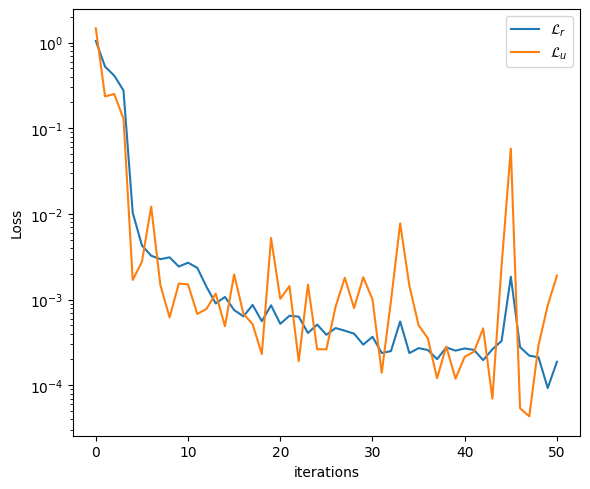

In [ ]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
#loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
#plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
example = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, k,l)
R_star = r(X_star, k, l)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 3.687903e-02


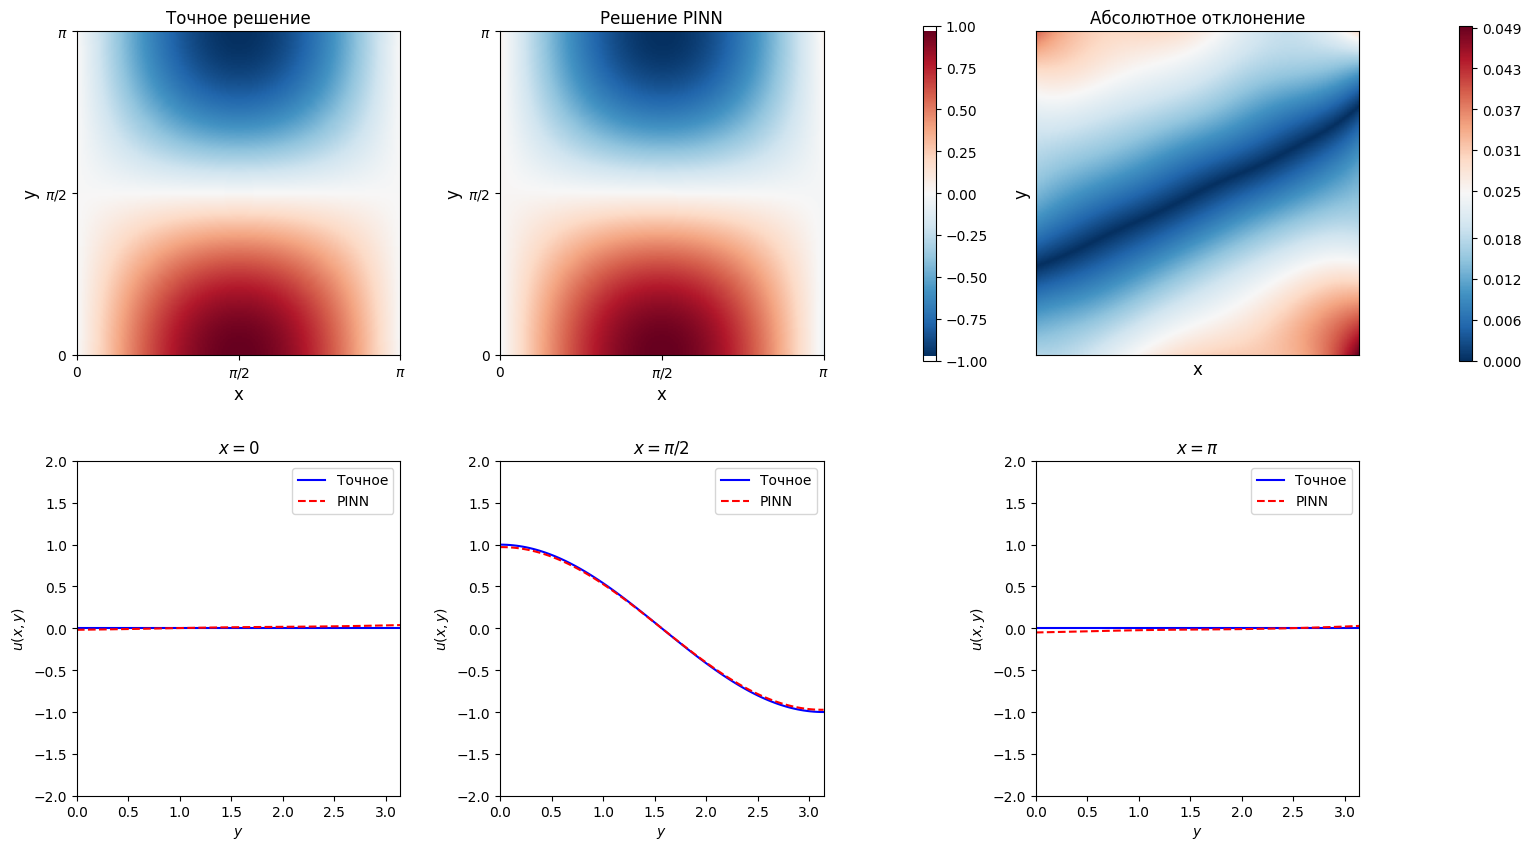

In [ ]:
visualize_solution(model)

$k=3$, $\,l=3$

$u=\sin{3x}\cos{3y}$

In [ ]:
# Define PINN model
k = 3
l = 3

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, bcs_sampler, res_sampler, k, l, kernel_size)

In [ ]:
# Train model
itertaions =10001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 8.314e+01, Loss_res: 8.152e+01,  Loss_bcs: 1.621e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
Compute NTK...
It: 100, Loss: 1.214e+04, Loss_res: 7.142e+01,  Loss_bcs: 2.374e+01
lambda_u: 1.005930e+00
lambda_r: 1.696312e+02
Compute NTK...
It: 200, Loss: 1.377e+02, Loss_res: 8.095e+01,  Loss_bcs: 8.906e-01
lambda_u: 2.483278e+00
lambda_r: 1.674182e+00
Compute NTK...
It: 300, Loss: 1.096e+02, Loss_res: 7.862e+01,  Loss_bcs: 9.148e-01
lambda_u: 3.859653e+00
lambda_r: 1.349693e+00
Compute NTK...
It: 400, Loss: 6.669e+01, Loss_res: 4.778e+01,  Loss_bcs: 8.596e-01
lambda_u: 4.107365e+00
lambda_r: 1.321816e+00
Compute NTK...
It: 500, Loss: 5.606e+01, Loss_res: 4.240e+01,  Loss_bcs: 3.282e-01
lambda_u: 3.812061e+01
lambda_r: 1.026939e+00
Compute NTK...
It: 600, Loss: 4.737e+01, Loss_res: 3.609e+01,  Loss_bcs: 1.442e-01
lambda_u: 7.491255e+01
lambda_r: 1.013530e+00
Compute NTK...
It: 700, Loss: 3.865e+01, Loss_res: 3.172e+01,  Loss_bcs: 6.979e-02
lambda_u: 9.441111e+01
lambda_r

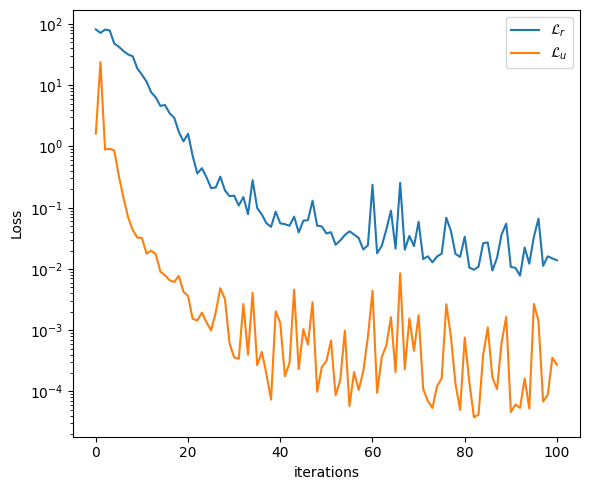

In [ ]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
#loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
#plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
example = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, k,l)
R_star = r(X_star, k, l)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 1.392899e-02


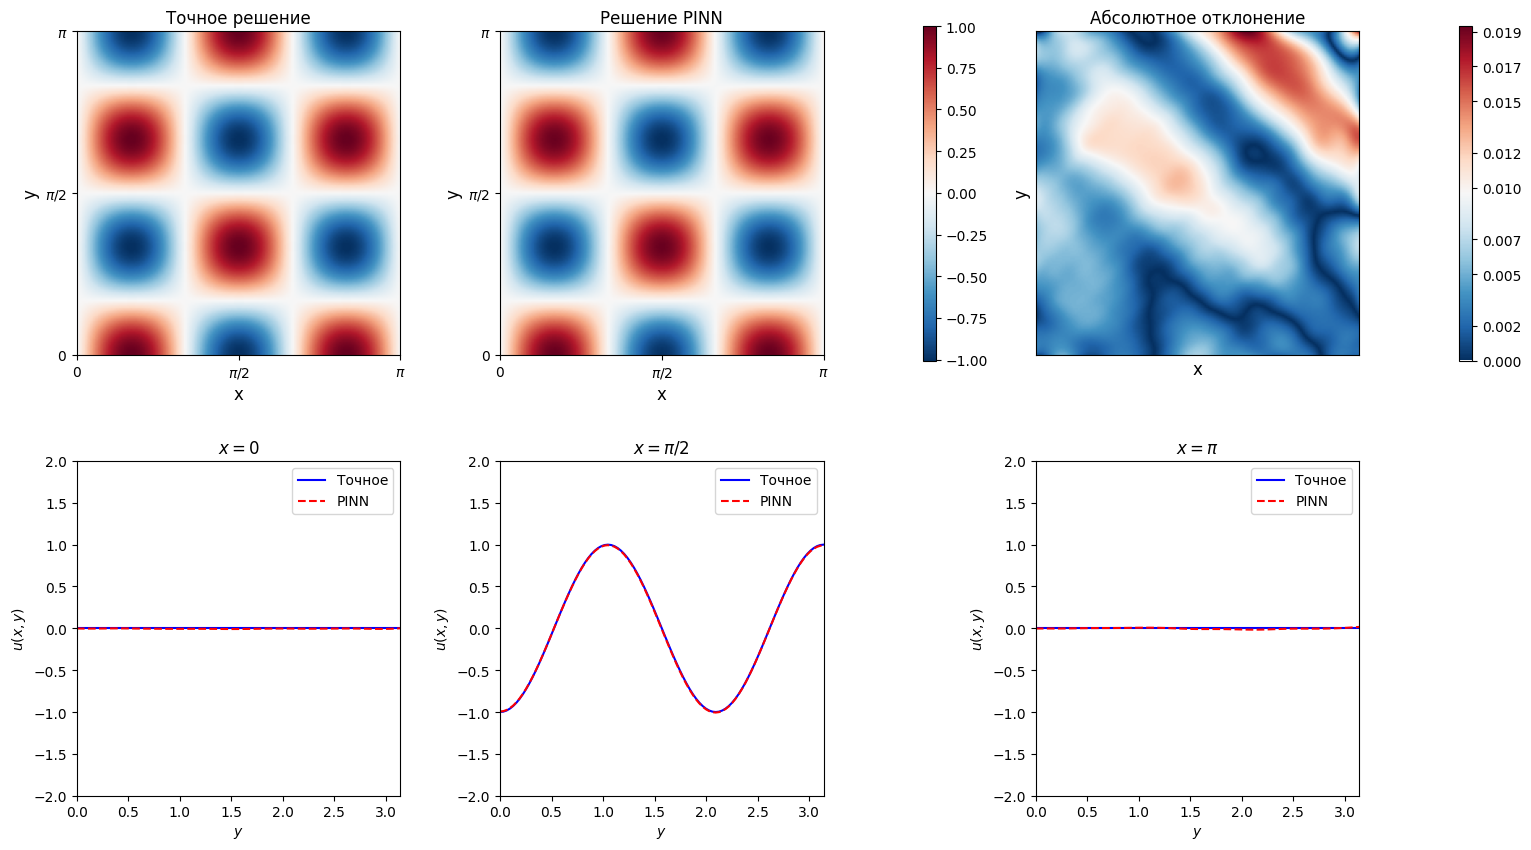

In [ ]:
visualize_solution(model)

$k=1$, $\,l=10$

$u=\sin{x}\cos{10y}$

In [8]:
# Define PINN model
k = 1
l = 10

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, bcs_sampler, res_sampler, k, l, kernel_size)

In [9]:
# Train model
itertaions =20001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


It: 0, Loss: 2.454e+03, Loss_res: 2.453e+03,  Loss_bcs: 8.903e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
Compute NTK...
It: 100, Loss: 4.462e+05, Loss_res: 2.663e+03,  Loss_bcs: 1.798e+00
lambda_u: 1.006003e+00
lambda_r: 1.675949e+02
Compute NTK...
It: 200, Loss: 2.354e+05, Loss_res: 2.443e+03,  Loss_bcs: 3.125e+01
lambda_u: 1.010490e+00
lambda_r: 9.633341e+01
Compute NTK...
It: 300, Loss: 2.490e+03, Loss_res: 2.338e+03,  Loss_bcs: 3.633e-01
lambda_u: 4.007371e+02
lambda_r: 1.002502e+00
Compute NTK...
It: 400, Loss: 2.016e+03, Loss_res: 1.944e+03,  Loss_bcs: 2.699e-01
lambda_u: 2.363958e+02
lambda_r: 1.004248e+00
Compute NTK...
It: 500, Loss: 2.313e+03, Loss_res: 2.250e+03,  Loss_bcs: 1.508e-01
lambda_u: 3.731817e+02
lambda_r: 1.002687e+00
Compute NTK...
It: 600, Loss: 2.152e+03, Loss_res: 2.117e+03,  Loss_bcs: 7.312e-02
lambda_u: 4.114612e+02
lambda_r: 1.002436e+00
Compute NTK...
It: 700, Loss: 1.906e+03, Loss_res: 1.876e+03,  Loss_bcs: 4.343e-02
lambda_u: 6.215877e+02
lambda_r

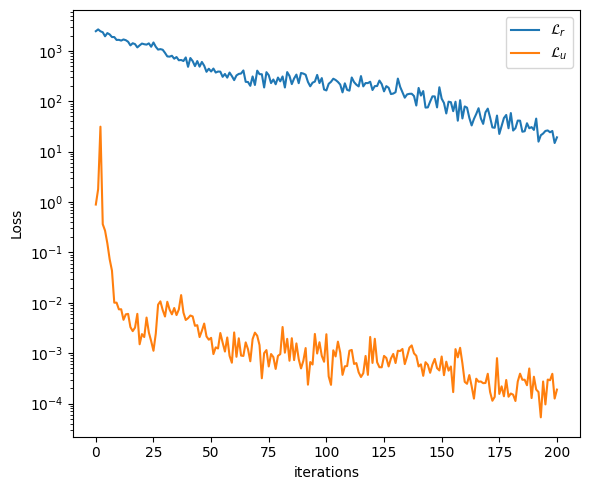

In [10]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
#loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
#plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
example = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, k,l)
R_star = r(X_star, k, l)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 5.420626e-01


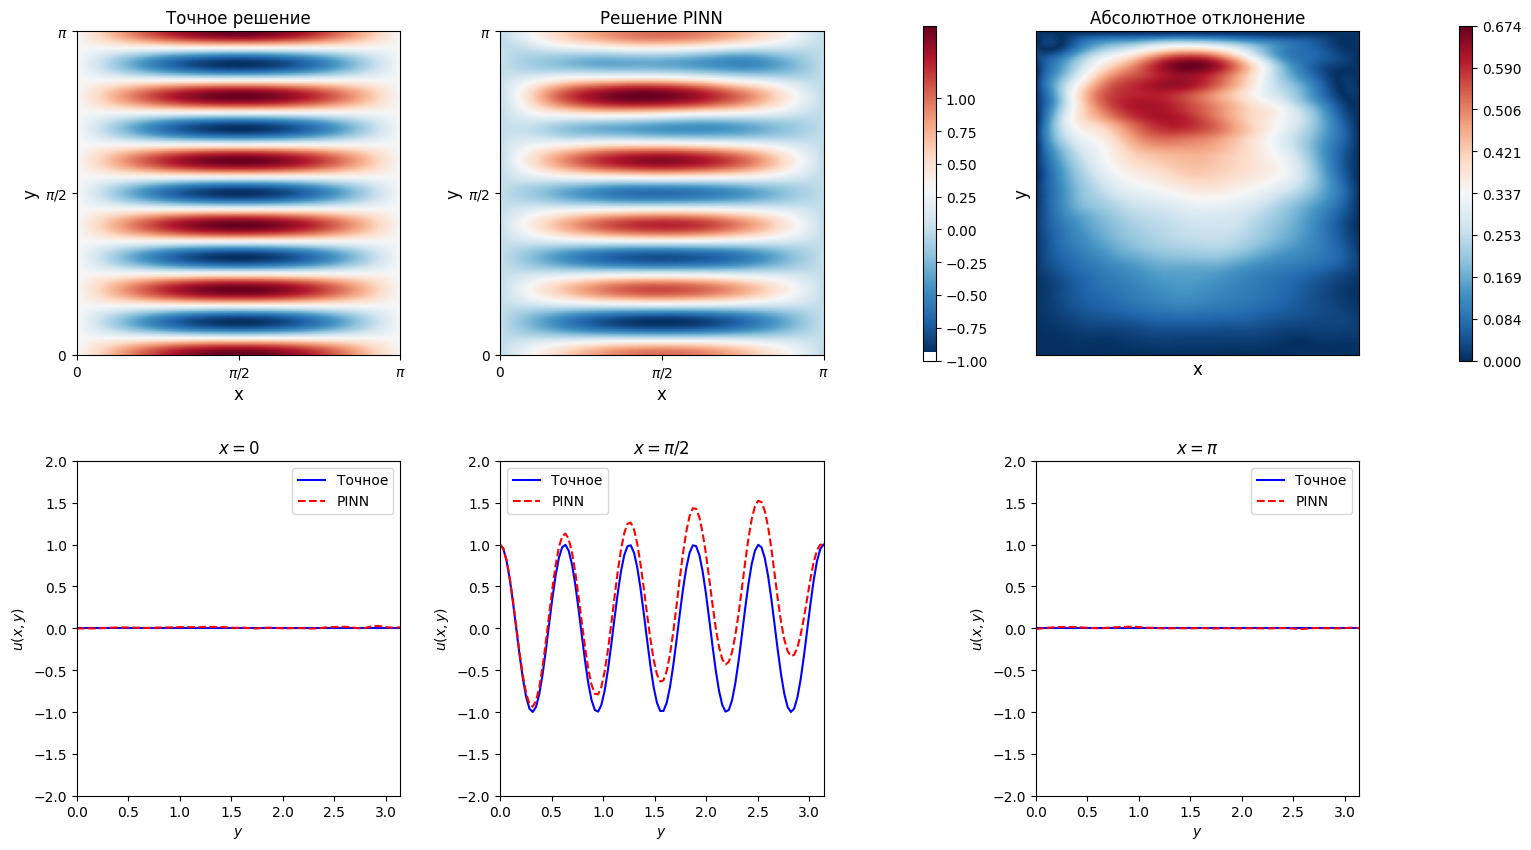

In [12]:
visualize_solution(model)

In [13]:
# Train model
itertaions =10001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 2.437e+01, Loss_res: 2.243e+01,  Loss_bcs: 1.910e-04
lambda_u: 1.013156e+04
lambda_r: 1.000099e+00
Compute NTK...
It: 100, Loss: 1.281e+01, Loss_res: 1.169e+01,  Loss_bcs: 1.019e-04
lambda_u: 1.092207e+04
lambda_r: 1.000092e+00
Compute NTK...
It: 200, Loss: 1.298e+01, Loss_res: 1.165e+01,  Loss_bcs: 1.410e-04
lambda_u: 9.431562e+03
lambda_r: 1.000106e+00
Compute NTK...
It: 300, Loss: 1.534e+01, Loss_res: 1.460e+01,  Loss_bcs: 6.741e-05
lambda_u: 1.095095e+04
lambda_r: 1.000091e+00
Compute NTK...
It: 400, Loss: 2.016e+01, Loss_res: 1.820e+01,  Loss_bcs: 1.784e-04
lambda_u: 1.093078e+04
lambda_r: 1.000092e+00
Compute NTK...
It: 500, Loss: 2.599e+01, Loss_res: 2.385e+01,  Loss_bcs: 1.712e-04
lambda_u: 1.247876e+04
lambda_r: 1.000080e+00
Compute NTK...
It: 600, Loss: 1.795e+01, Loss_res: 1.500e+01,  Loss_bcs: 2.043e-04
lambda_u: 1.444841e+04
lambda_r: 1.000069e+00
Compute NTK...
It: 700, Loss: 2.800e+01, Loss_res: 2.585e+01,  Loss_bcs: 1.893e-04
lambda_u: 1.139516e+04
lambda_r

In [14]:
example = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, k,l)
R_star = r(X_star, k, l)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 1.746658e-01


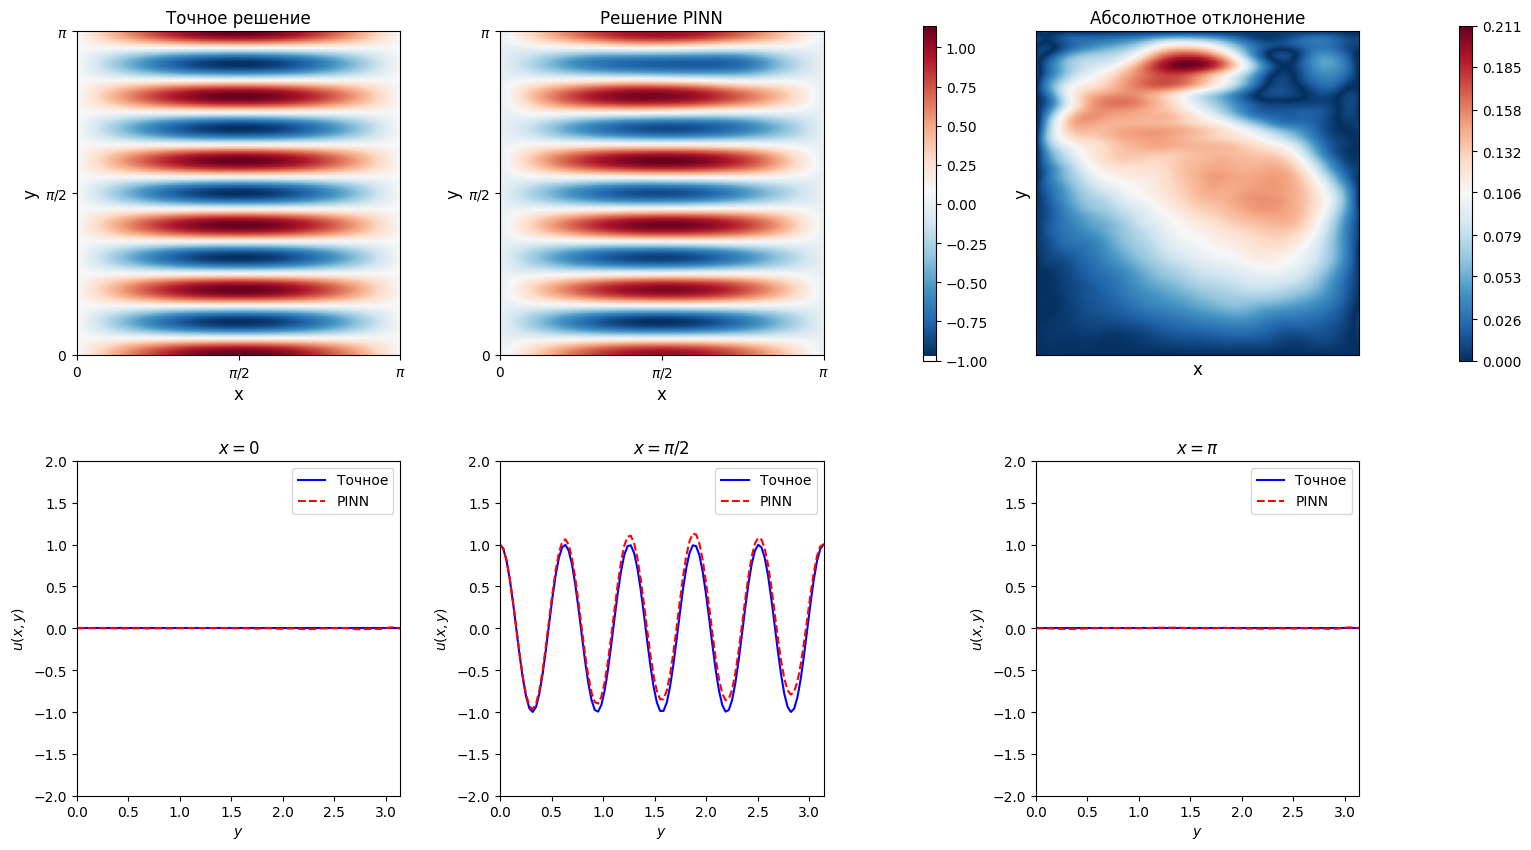

In [15]:
visualize_solution(model)

In [16]:
# Train model
itertaions =10001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 3.791e+00, Loss_res: 3.280e+00,  Loss_bcs: 4.969e-05
lambda_u: 1.028600e+04
lambda_r: 1.000097e+00
Compute NTK...
It: 100, Loss: 4.455e+00, Loss_res: 4.258e+00,  Loss_bcs: 2.399e-05
lambda_u: 8.200486e+03
lambda_r: 1.000122e+00
Compute NTK...
It: 200, Loss: 3.434e+00, Loss_res: 3.210e+00,  Loss_bcs: 1.900e-05
lambda_u: 1.175419e+04
lambda_r: 1.000085e+00
Compute NTK...
It: 300, Loss: 5.222e+00, Loss_res: 4.022e+00,  Loss_bcs: 1.083e-04
lambda_u: 1.107837e+04
lambda_r: 1.000090e+00
Compute NTK...
It: 400, Loss: 4.020e+00, Loss_res: 3.790e+00,  Loss_bcs: 3.055e-05
lambda_u: 7.503996e+03
lambda_r: 1.000133e+00
Compute NTK...
It: 500, Loss: 5.780e+00, Loss_res: 5.477e+00,  Loss_bcs: 3.028e-05
lambda_u: 1.000601e+04
lambda_r: 1.000100e+00
Compute NTK...
It: 600, Loss: 5.617e+00, Loss_res: 5.196e+00,  Loss_bcs: 2.973e-05
lambda_u: 1.415104e+04
lambda_r: 1.000071e+00
Compute NTK...
It: 700, Loss: 5.309e+00, Loss_res: 4.834e+00,  Loss_bcs: 4.896e-05
lambda_u: 9.689778e+03
lambda_r

In [17]:
example = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, k,l)
R_star = r(X_star, k, l)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 7.465005e-02


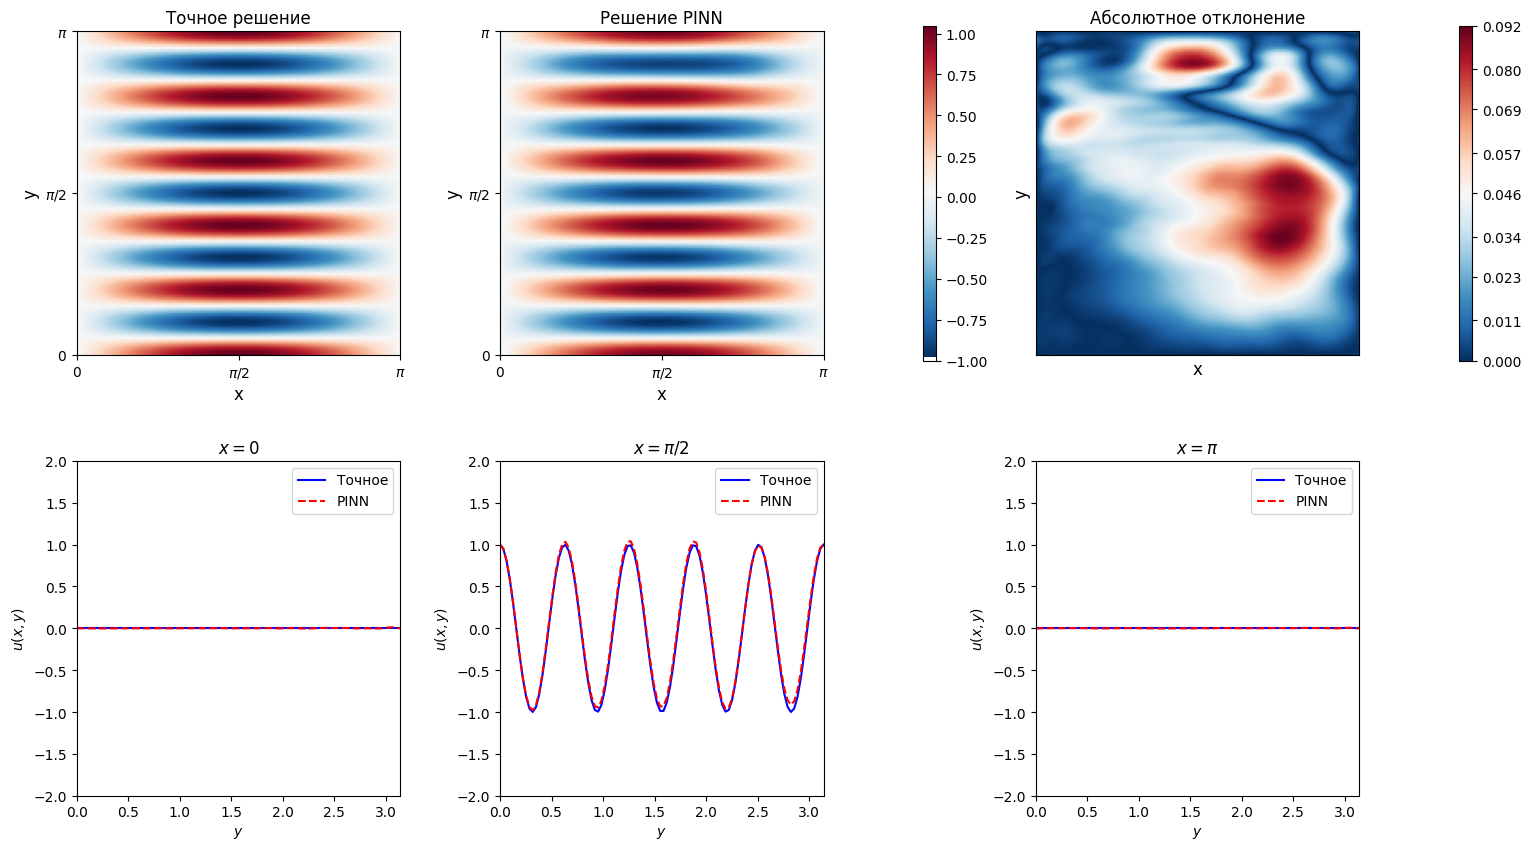

In [18]:
visualize_solution(model)